# Predicting Tree Cover Change
Use World Bank Tree cover data and a LSTM Neural Network to predict tree cover changes across the world. 

## Imports

In [87]:
!pip install category_encoders

In [621]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

from matplotlib import pyplot

from math import sqrt

from numpy import array

import category_encoders as ce

from sklearn.metrics import mean_squared_error

from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense

## Loading the data
Data sourced from [The World Bank.](https://data.worldbank.org/indicator/AG.LND.FRST.ZS)

In [8]:
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [329]:
tree = pd.read_csv('./data/forestCoverage.csv')

In [354]:
tree.head()

,Unnamed: 0,Country Name,Country Code,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,0,Aruba,ABW,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333
1,1,Afghanistan,AFG,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825,2.067825
2,2,Angola,AGO,48.909922,48.809817,48.709712,48.609611,48.509506,48.409401,48.309296,48.209191,48.109089,48.008984,47.908879,47.808775,47.708670,47.608568,47.508463,47.408358,47.308253,47.208148,47.108046,47.007942,46.907837,46.807732,46.707627,46.607525,46.507420,46.407315,46.307210
3,3,Albania,ALB,28.788321,28.717152,28.645986,28.574818,28.503650,28.432481,28.361313,28.290147,28.218979,28.147810,28.076642,28.172262,28.267882,28.363503,28.459125,28.554745,28.510219,28.465694,28.421168,28.376643,28.332116,28.297081,28.262044,28.227007,28.191972,28.156934,28.121897
4,4,Andorra,AND,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553,34.042553


In [623]:
tree = tree.dropna()

## Baseline RMSE with walk forward prediction

In [401]:
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
def model_persistence(x):
	return x

def basic_predictor(country_code):
    series = [int(x) for x in tree.columns[3:]]
    # Create lagged dataset
    values = DataFrame(tree[tree['Country Code'] == country_code].values[0][3:])
    dataframe = concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t-1', 't+1']
    print(dataframe.head(5))

    # split into train and test sets
    X = dataframe.values
    train_size = int(len(X) * 0.66)
    train, test = X[1:train_size], X[train_size:]
    train_X, train_y = train[:,0], train[:,1]
    test_X, test_y = test[:,0], test[:,1]


    # walk-forward validation
    predictions = list()
    for x in test_X:
        yhat = model_persistence(x)
        predictions.append(yhat)
    test_score = mean_squared_error(test_y, predictions) ** .5
    print('Test RMSE: %.3f' % test_score)

In [403]:
basic_predictor('COL')

       t-1      t+1
0      NaN  58.0595
1  58.0595  57.8235
2  57.8235  57.5875
3  57.5875  57.3514
4  57.3514  57.1154
Test RMSE: 0.180


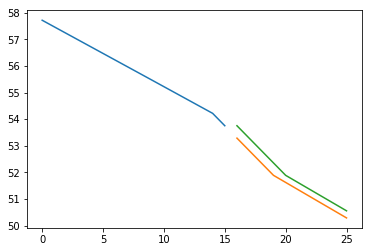

In [404]:
pyplot.plot(train_y)
pyplot.plot([None for i in train_y] + [x for x in test_y])
pyplot.plot([None for i in train_y] + [x for x in predictions])
pyplot.show()

## LSTM implementation
See Jason Brownlee's [tutorial](https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/) for more.

In [606]:
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    # transform data to be stationary
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # rescale values to -1, 1
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    '''
    Provides RMSE given test values, forecast values, n_lag and n_seq. 
    '''
    rmses = []
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        rmses.append(rmse)
        return rmses

In [632]:
def country_predictor(country_code, n_lag=1, n_seq=21, n_test=1, n_epochs=150, n_batch=1, n_neurons=1):
    '''
    Takes country code of column of dataset and returns predictions. 
    '''
    # load dataset
    series = DataFrame(tree[tree['Country Code'] == country_code].values[0][3:])
    # prepare data
    scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
    # fit model
    model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)
    # make forecasts
    forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler, n_test+10)
    actual = [row[n_lag:] for row in test]
    actual = inverse_transform(series, actual, scaler, n_test+10)
    # evaluate forecasts
    evaluations = evaluate_forecasts(actual, forecasts, n_lag, n_seq)
    return forecasts

In [633]:
def country_iterator(df, max_columns=-1):
    '''
    Iterates through countries and adds 10 years of predictions to dataframe.
    Depends on country_predictor function to create predictions. 
    ----
    df: dataframe with countrys as columns and time series as observations.
    max_columns: how many columns you are interested in getting predictions for. 
    Defaults to all columns of df.
    '''
    init = country_predictor(df.iloc[1,2])[0][-10:]
    results_df = DataFrame([x for x in range(2017, 2027)], columns=['Year'])
    evaluations = []
    for country in tree.iloc[:max_columns, 2].values:
        result = country_predictor(country)[0][-10:]
        results_df[country] = [x[0] for x in result]
        evaluations.append(evaluation)
    return results_df

In [634]:
sample, evals = country_iterator(tree, 3)

/Users/oliver/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/oliver/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


NameError: name 'evaluation' is not defined

In [613]:
# Creation of predictions dataframe. May take a few hours to run. 
pred_df = country_iterator(tree)

/Users/oliver/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/oliver/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/oliver/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/oliver/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/oliver/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: 

In [615]:
# Export predictions df to csv. 
pred_df.to_csv('forest_predictions.csv')